In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [ ]:
# STEP 1: Load data
url = "https://docs.google.com/spreadsheets/d/10oq0gqZKdI-wg0PSQmVnBWf8fhc6qH4DG91YTKehH-A/export?format=csv"
df = pd.read_csv(url)
df.head()

,DateTime,Junction,Vehicles,ID,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,Date,event_name,event_type,city,sports_event,concert,public_holiday,public_demonstration
0,2015-11-01 0:00:00,1,15,20151101001,0.366609,0.715399,0.0,0.144331,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
1,2015-11-01 1:00:00,1,13,20151101011,0.342513,0.761021,0.0,0.156549,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
2,2015-11-01 2:00:00,1,10,20151101021,0.314974,0.803642,0.0,0.143348,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
3,2015-11-01 3:00:00,1,7,20151101031,0.301205,0.820109,0.0,0.151966,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
4,2015-11-01 4:00:00,1,9,20151101041,0.292599,0.825532,0.0,0.190746,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration


In [ ]:
# STEP 2: Check missing values
df.isnull().sum()

DateTime                    0
Junction                    0
Vehicles                    0
ID                          0
temperature_2m              0
relative_humidity_2m        0
precipitation               0
wind_speed_10m              0
Date                        0
event_name                  0
event_type              44832
city                    44832
sports_event                0
concert                     0
public_holiday              0
public_demonstration        0
dtype: int64

In [ ]:
# STEP 3: Handle missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')

categorical_cols = df.select_dtypes(exclude=[np.number]).columns
for col in categorical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

In [ ]:
# STEP 4: Remove duplicates
df = df.drop_duplicates()

In [ ]:
# STEP 5: Convert data types
if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'])

if 'Vehicles' in df.columns:
    df['Vehicles'] = pd.to_numeric(df['Vehicles'], errors='coerce')

if 'Junction' in df.columns:
    df['Junction'] = pd.to_numeric(df['Junction'], errors='coerce')

df.dtypes

DateTime                datetime64[ns]
Junction                         int64
Vehicles                         int64
ID                               int64
temperature_2m                 float64
relative_humidity_2m           float64
precipitation                  float64
wind_speed_10m                 float64
Date                            object
event_name                      object
event_type                      object
city                            object
sports_event                    object
concert                         object
public_holiday                  object
public_demonstration            object
dtype: object

In [ ]:
# STEP 6: Extract datetime components
if 'DateTime' in df.columns:
    df['Date'] = df['DateTime'].dt.date
    df['Hour'] = df['DateTime'].dt.hour
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['Month'] = df['DateTime'].dt.month
    df['Year'] = df['DateTime'].dt.year

df.head()

,DateTime,Junction,Vehicles,ID,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,Date,event_name,event_type,city,sports_event,concert,public_holiday,public_demonstration,Hour,DayOfWeek,Month,Year
0,2015-11-01 00:00:00,1,15,20151101001,0.366609,0.715399,0.0,0.144331,2015-11-01,No Event,holiday,Hyderabad,No Sport,No concert,No holding,No demonstration,0,6,11,2015
1,2015-11-01 01:00:00,1,13,20151101011,0.342513,0.761021,0.0,0.156549,2015-11-01,No Event,holiday,Hyderabad,No Sport,No concert,No holding,No demonstration,1,6,11,2015
2,2015-11-01 02:00:00,1,10,20151101021,0.314974,0.803642,0.0,0.143348,2015-11-01,No Event,holiday,Hyderabad,No Sport,No concert,No holding,No demonstration,2,6,11,2015
3,2015-11-01 03:00:00,1,7,20151101031,0.301205,0.820109,0.0,0.151966,2015-11-01,No Event,holiday,Hyderabad,No Sport,No concert,No holding,No demonstration,3,6,11,2015
4,2015-11-01 04:00:00,1,9,20151101041,0.292599,0.825532,0.0,0.190746,2015-11-01,No Event,holiday,Hyderabad,No Sport,No concert,No holding,No demonstration,4,6,11,2015


In [ ]:
# STEP 7: Aggregate by Junction and Hour
hourly_traffic = df.groupby(['Junction', 'Hour'])['Vehicles'].sum().reset_index()
hourly_traffic.head(10)

,Junction,Hour,Vehicles
0,1,0,27809
1,1,1,23807
2,1,2,20616
3,1,3,17894
4,1,4,15598
5,1,5,14633
6,1,6,15857
7,1,7,17952
8,1,8,19903
9,1,9,23714


In [ ]:
# STEP 8: Detailed aggregation by Junction, Date, Hour
if 'DateTime' in df.columns:
    detailed_aggregation = df.groupby(['Junction', 'Date', 'Hour']).agg({
        'Vehicles': 'sum'
    }).reset_index()

detailed_aggregation.head(10)

,Junction,Date,Hour,Vehicles
0,1,2015-11-01,0,15
1,1,2015-11-01,1,13
2,1,2015-11-01,2,10
3,1,2015-11-01,3,7
4,1,2015-11-01,4,9
5,1,2015-11-01,5,6
6,1,2015-11-01,6,9
7,1,2015-11-01,7,8
8,1,2015-11-01,8,11
9,1,2015-11-01,9,12


In [ ]:
# STEP 9: Normalize using MinMaxScaler
normalized_traffic = hourly_traffic.copy()
scaler = MinMaxScaler()
normalized_traffic['Vehicles_scaled'] = scaler.fit_transform(normalized_traffic[['Vehicles']])
normalized_traffic.head(10)

,Junction,Hour,Vehicles,Vehicles_scaled
0,1,0,27809,0.773385
1,1,1,23807,0.659221
2,1,2,20616,0.568193
3,1,3,17894,0.490543
4,1,4,15598,0.425046
5,1,5,14633,0.397518
6,1,6,15857,0.432435
7,1,7,17952,0.492198
8,1,8,19903,0.547853
9,1,9,23714,0.656568


In [ ]:
# STEP 10: Save as preprocessed data
preprocessed_data = normalized_traffic.copy()

In [ ]:
# STEP 11: Create feature dataframe
if 'DateTime' in df.columns:
    feature_df = detailed_aggregation.copy()
    feature_df = feature_df.merge(
        df[['Date', 'Hour', 'DayOfWeek', 'Month', 'Year']].drop_duplicates(),
        on=['Date', 'Hour'],
        how='left'
    )
else:
    feature_df = preprocessed_data.copy()

feature_df.head()

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year
0,1,2015-11-01,0,15,6,11,2015
1,1,2015-11-01,1,13,6,11,2015
2,1,2015-11-01,2,10,6,11,2015
3,1,2015-11-01,3,7,6,11,2015
4,1,2015-11-01,4,9,6,11,2015


In [ ]:
# STEP 12: Create cyclical features
feature_df['Hour_sin'] = np.sin(2 * np.pi * feature_df['Hour'] / 24)
feature_df['Hour_cos'] = np.cos(2 * np.pi * feature_df['Hour'] / 24)
feature_df['DayOfWeek_sin'] = np.sin(2 * np.pi * feature_df['DayOfWeek'] / 7)
feature_df['DayOfWeek_cos'] = np.cos(2 * np.pi * feature_df['DayOfWeek'] / 7)

feature_df.head()

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos
0,1,2015-11-01,0,15,6,11,2015,0.000000,1.000000,-0.781831,0.62349
1,1,2015-11-01,1,13,6,11,2015,0.258819,0.965926,-0.781831,0.62349
2,1,2015-11-01,2,10,6,11,2015,0.500000,0.866025,-0.781831,0.62349
3,1,2015-11-01,3,7,6,11,2015,0.707107,0.707107,-0.781831,0.62349
4,1,2015-11-01,4,9,6,11,2015,0.866025,0.500000,-0.781831,0.62349


In [ ]:
# STEP 13: Sort data for lag features
feature_df = feature_df.sort_values(['Junction', 'Date', 'Hour'])

In [ ]:
# STEP 14: Create lag features
for lag in [1, 2, 3, 6, 12, 24]:
    feature_df[f'Vehicles_lag_{lag}h'] = feature_df.groupby('Junction')['Vehicles'].shift(lag)

feature_df.head(10)

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h
0,1,2015-11-01,0,15,6,11,2015,0.000000,1.000000e+00,-0.781831,0.62349,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015-11-01,1,13,6,11,2015,0.258819,9.659258e-01,-0.781831,0.62349,15.0,NaN,NaN,NaN,NaN,NaN
2,1,2015-11-01,2,10,6,11,2015,0.500000,8.660254e-01,-0.781831,0.62349,13.0,15.0,NaN,NaN,NaN,NaN
3,1,2015-11-01,3,7,6,11,2015,0.707107,7.071068e-01,-0.781831,0.62349,10.0,13.0,15.0,NaN,NaN,NaN
4,1,2015-11-01,4,9,6,11,2015,0.866025,5.000000e-01,-0.781831,0.62349,7.0,10.0,13.0,NaN,NaN,NaN
5,1,2015-11-01,5,6,6,11,2015,0.965926,2.588190e-01,-0.781831,0.62349,9.0,7.0,10.0,NaN,NaN,NaN
6,1,2015-11-01,6,9,6,11,2015,1.000000,6.123234e-17,-0.781831,0.62349,6.0,9.0,7.0,15.0,NaN,NaN
7,1,2015-11-01,7,8,6,11,2015,0.965926,-2.588190e-01,-0.781831,0.62349,9.0,6.0,9.0,13.0,NaN,NaN
8,1,2015-11-01,8,11,6,11,2015,0.866025,-5.000000e-01,-0.781831,0.62349,8.0,9.0,6.0,10.0,NaN,NaN
9,1,2015-11-01,9,12,6,11,2015,0.707107,-7.071068e-01,-0.781831,0.62349,11.0,8.0,9.0,7.0,NaN,NaN


In [ ]:
# STEP 15: Create rolling mean features
feature_df['Vehicles_rolling_mean_3h'] = feature_df.groupby('Junction')['Vehicles'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
feature_df['Vehicles_rolling_mean_6h'] = feature_df.groupby('Junction')['Vehicles'].transform(
    lambda x: x.rolling(window=6, min_periods=1).mean()
)

feature_df.head(10)

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h
0,1,2015-11-01,0,15,6,11,2015,0.000000,1.000000e+00,-0.781831,0.62349,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,15.000000
1,1,2015-11-01,1,13,6,11,2015,0.258819,9.659258e-01,-0.781831,0.62349,15.0,NaN,NaN,NaN,NaN,NaN,14.000000,14.000000
2,1,2015-11-01,2,10,6,11,2015,0.500000,8.660254e-01,-0.781831,0.62349,13.0,15.0,NaN,NaN,NaN,NaN,12.666667,12.666667
3,1,2015-11-01,3,7,6,11,2015,0.707107,7.071068e-01,-0.781831,0.62349,10.0,13.0,15.0,NaN,NaN,NaN,10.000000,11.250000
4,1,2015-11-01,4,9,6,11,2015,0.866025,5.000000e-01,-0.781831,0.62349,7.0,10.0,13.0,NaN,NaN,NaN,8.666667,10.800000
5,1,2015-11-01,5,6,6,11,2015,0.965926,2.588190e-01,-0.781831,0.62349,9.0,7.0,10.0,NaN,NaN,NaN,7.333333,10.000000
6,1,2015-11-01,6,9,6,11,2015,1.000000,6.123234e-17,-0.781831,0.62349,6.0,9.0,7.0,15.0,NaN,NaN,8.000000,9.000000
7,1,2015-11-01,7,8,6,11,2015,0.965926,-2.588190e-01,-0.781831,0.62349,9.0,6.0,9.0,13.0,NaN,NaN,7.666667,8.166667
8,1,2015-11-01,8,11,6,11,2015,0.866025,-5.000000e-01,-0.781831,0.62349,8.0,9.0,6.0,10.0,NaN,NaN,9.333333,8.333333
9,1,2015-11-01,9,12,6,11,2015,0.707107,-7.071068e-01,-0.781831,0.62349,11.0,8.0,9.0,7.0,NaN,NaN,10.333333,9.166667


In [ ]:
# STEP 16: Create weekend indicator
feature_df['IsWeekend'] = (feature_df['DayOfWeek'] >= 5).astype(int)

feature_df.head()

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h,IsWeekend
0,1,2015-11-01,0,15,6,11,2015,0.000000,1.000000,-0.781831,0.62349,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,15.000000,1
1,1,2015-11-01,1,13,6,11,2015,0.258819,0.965926,-0.781831,0.62349,15.0,NaN,NaN,NaN,NaN,NaN,14.000000,14.000000,1
2,1,2015-11-01,2,10,6,11,2015,0.500000,0.866025,-0.781831,0.62349,13.0,15.0,NaN,NaN,NaN,NaN,12.666667,12.666667,1
3,1,2015-11-01,3,7,6,11,2015,0.707107,0.707107,-0.781831,0.62349,10.0,13.0,15.0,NaN,NaN,NaN,10.000000,11.250000,1
4,1,2015-11-01,4,9,6,11,2015,0.866025,0.500000,-0.781831,0.62349,7.0,10.0,13.0,NaN,NaN,NaN,8.666667,10.800000,1


In [ ]:
# STEP 17: Create rush hour indicators
feature_df['IsMorningRush'] = ((feature_df['Hour'] >= 7) & (feature_df['Hour'] <= 10)).astype(int)
feature_df['IsEveningRush'] = ((feature_df['Hour'] >= 17) & (feature_df['Hour'] <= 20)).astype(int)
feature_df['IsRushHour'] = ((feature_df['IsMorningRush'] == 1) | (feature_df['IsEveningRush'] == 1)).astype(int)

feature_df.head()

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h,IsWeekend,IsMorningRush,IsEveningRush,IsRushHour
0,1,2015-11-01,0,15,6,11,2015,0.000000,1.000000,-0.781831,0.62349,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,15.000000,1,0,0,0
1,1,2015-11-01,1,13,6,11,2015,0.258819,0.965926,-0.781831,0.62349,15.0,NaN,NaN,NaN,NaN,NaN,14.000000,14.000000,1,0,0,0
2,1,2015-11-01,2,10,6,11,2015,0.500000,0.866025,-0.781831,0.62349,13.0,15.0,NaN,NaN,NaN,NaN,12.666667,12.666667,1,0,0,0
3,1,2015-11-01,3,7,6,11,2015,0.707107,0.707107,-0.781831,0.62349,10.0,13.0,15.0,NaN,NaN,NaN,10.000000,11.250000,1,0,0,0
4,1,2015-11-01,4,9,6,11,2015,0.866025,0.500000,-0.781831,0.62349,7.0,10.0,13.0,NaN,NaN,NaN,8.666667,10.800000,1,0,0,0


In [ ]:
# STEP 18: Create special event indicator
feature_df['IsSpecialEvent'] = 0

feature_df.head()

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h,IsWeekend,IsMorningRush,IsEveningRush,IsRushHour,IsSpecialEvent
0,1,2015-11-01,0,15,6,11,2015,0.000000,1.000000,-0.781831,0.62349,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,15.000000,1,0,0,0,0
1,1,2015-11-01,1,13,6,11,2015,0.258819,0.965926,-0.781831,0.62349,15.0,NaN,NaN,NaN,NaN,NaN,14.000000,14.000000,1,0,0,0,0
2,1,2015-11-01,2,10,6,11,2015,0.500000,0.866025,-0.781831,0.62349,13.0,15.0,NaN,NaN,NaN,NaN,12.666667,12.666667,1,0,0,0,0
3,1,2015-11-01,3,7,6,11,2015,0.707107,0.707107,-0.781831,0.62349,10.0,13.0,15.0,NaN,NaN,NaN,10.000000,11.250000,1,0,0,0,0
4,1,2015-11-01,4,9,6,11,2015,0.866025,0.500000,-0.781831,0.62349,7.0,10.0,13.0,NaN,NaN,NaN,8.666667,10.800000,1,0,0,0,0


In [ ]:
# STEP 19: Create time of day categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

feature_df['TimeOfDay'] = feature_df['Hour'].apply(categorize_time)

feature_df.head()

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h,IsWeekend,IsMorningRush,IsEveningRush,IsRushHour,IsSpecialEvent,TimeOfDay
0,1,2015-11-01,0,15,6,11,2015,0.000000,1.000000,-0.781831,0.62349,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,15.000000,1,0,0,0,0,Night
1,1,2015-11-01,1,13,6,11,2015,0.258819,0.965926,-0.781831,0.62349,15.0,NaN,NaN,NaN,NaN,NaN,14.000000,14.000000,1,0,0,0,0,Night
2,1,2015-11-01,2,10,6,11,2015,0.500000,0.866025,-0.781831,0.62349,13.0,15.0,NaN,NaN,NaN,NaN,12.666667,12.666667,1,0,0,0,0,Night
3,1,2015-11-01,3,7,6,11,2015,0.707107,0.707107,-0.781831,0.62349,10.0,13.0,15.0,NaN,NaN,NaN,10.000000,11.250000,1,0,0,0,0,Night
4,1,2015-11-01,4,9,6,11,2015,0.866025,0.500000,-0.781831,0.62349,7.0,10.0,13.0,NaN,NaN,NaN,8.666667,10.800000,1,0,0,0,0,Night


In [ ]:
# STEP 20: Remove NaN values
analysis_df = feature_df.dropna()

analysis_df.shape

(48024, 25)

In [ ]:
# STEP 21: Select numeric features
numeric_features = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
if 'Date' in numeric_features:
    numeric_features.remove('Date')

numeric_features

['Junction',
 'Hour',
 'Vehicles',
 'DayOfWeek',
 'Month',
 'Year',
 'Hour_sin',
 'Hour_cos',
 'DayOfWeek_sin',
 'DayOfWeek_cos',
 'Vehicles_lag_1h',
 'Vehicles_lag_2h',
 'Vehicles_lag_3h',
 'Vehicles_lag_6h',
 'Vehicles_lag_12h',
 'Vehicles_lag_24h',
 'Vehicles_rolling_mean_3h',
 'Vehicles_rolling_mean_6h',
 'IsWeekend',
 'IsMorningRush',
 'IsEveningRush',
 'IsRushHour',
 'IsSpecialEvent']

In [ ]:
# STEP 22: Calculate correlation matrix
correlation_matrix = analysis_df[numeric_features].corr()

correlation_matrix.head()

,Junction,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h,IsWeekend,IsMorningRush,IsEveningRush,IsRushHour,IsSpecialEvent
Junction,1.000000e+00,-2.159099e-15,-0.614193,-1.657164e-03,-1.230177e-01,2.207096e-01,3.167864e-18,9.491754e-18,1.646636e-03,-3.749865e-04,-0.614185,-0.614198,-0.614199,-0.614274,-0.614292,-0.613890,-0.622738,-0.634857,-2.099867e-03,-1.417350e-15,7.387326e-16,-5.899382e-16,NaN
Hour,-2.159099e-15,1.000000e+00,0.220167,4.922266e-19,5.257389e-16,-2.603470e-15,-7.759122e-01,-1.021508e-01,-1.176434e-17,1.933908e-17,0.200565,0.169865,0.132343,-0.002375,-0.182920,0.219917,0.199606,0.144879,1.281343e-17,-1.938175e-01,4.522408e-01,2.043016e-01,NaN
Vehicles,-6.141932e-01,2.201674e-01,1.000000,-1.241237e-01,-2.190100e-02,2.205469e-01,-2.568968e-01,-6.187325e-02,1.288435e-01,-2.780226e-02,0.970122,0.937090,0.901064,0.783709,0.687973,0.905146,0.982556,0.946134,-1.486294e-01,-8.873920e-02,1.254451e-01,2.901854e-02,NaN
DayOfWeek,-1.657164e-03,4.922266e-19,-0.124124,1.000000e+00,-5.431359e-03,5.059544e-03,4.517464e-19,2.802137e-18,-7.327565e-01,-3.570383e-01,-0.120821,-0.116610,-0.111486,-0.091429,-0.038204,0.009410,-0.122195,-0.116701,7.891759e-01,-4.974296e-18,1.958042e-18,-1.696504e-18,NaN
Month,-1.230177e-01,5.257389e-16,-0.021901,-5.431359e-03,1.000000e+00,-6.217062e-01,1.785626e-18,-1.473354e-18,8.925652e-03,-8.603216e-03,-0.021698,-0.021450,-0.021233,-0.020477,-0.019309,-0.018188,-0.021985,-0.022051,-7.949083e-03,1.549829e-16,2.291909e-17,2.627234e-16,NaN


In [ ]:
# STEP 23: Get correlation with Vehicles
vehicle_correlation = correlation_matrix['Vehicles'].sort_values(ascending=False)

vehicle_correlation

Vehicles                    1.000000
Vehicles_rolling_mean_3h    0.982556
Vehicles_lag_1h             0.970122
Vehicles_rolling_mean_6h    0.946134
Vehicles_lag_2h             0.937090
Vehicles_lag_24h            0.905146
Vehicles_lag_3h             0.901064
Vehicles_lag_6h             0.783709
Vehicles_lag_12h            0.687973
Year                        0.220547
Hour                        0.220167
DayOfWeek_sin               0.128843
IsEveningRush               0.125445
IsRushHour                  0.029019
Month                      -0.021901
DayOfWeek_cos              -0.027802
Hour_cos                   -0.061873
IsMorningRush              -0.088739
DayOfWeek                  -0.124124
IsWeekend                  -0.148629
Hour_sin                   -0.256897
Junction                   -0.614193
IsSpecialEvent                   NaN
Name: Vehicles, dtype: float64

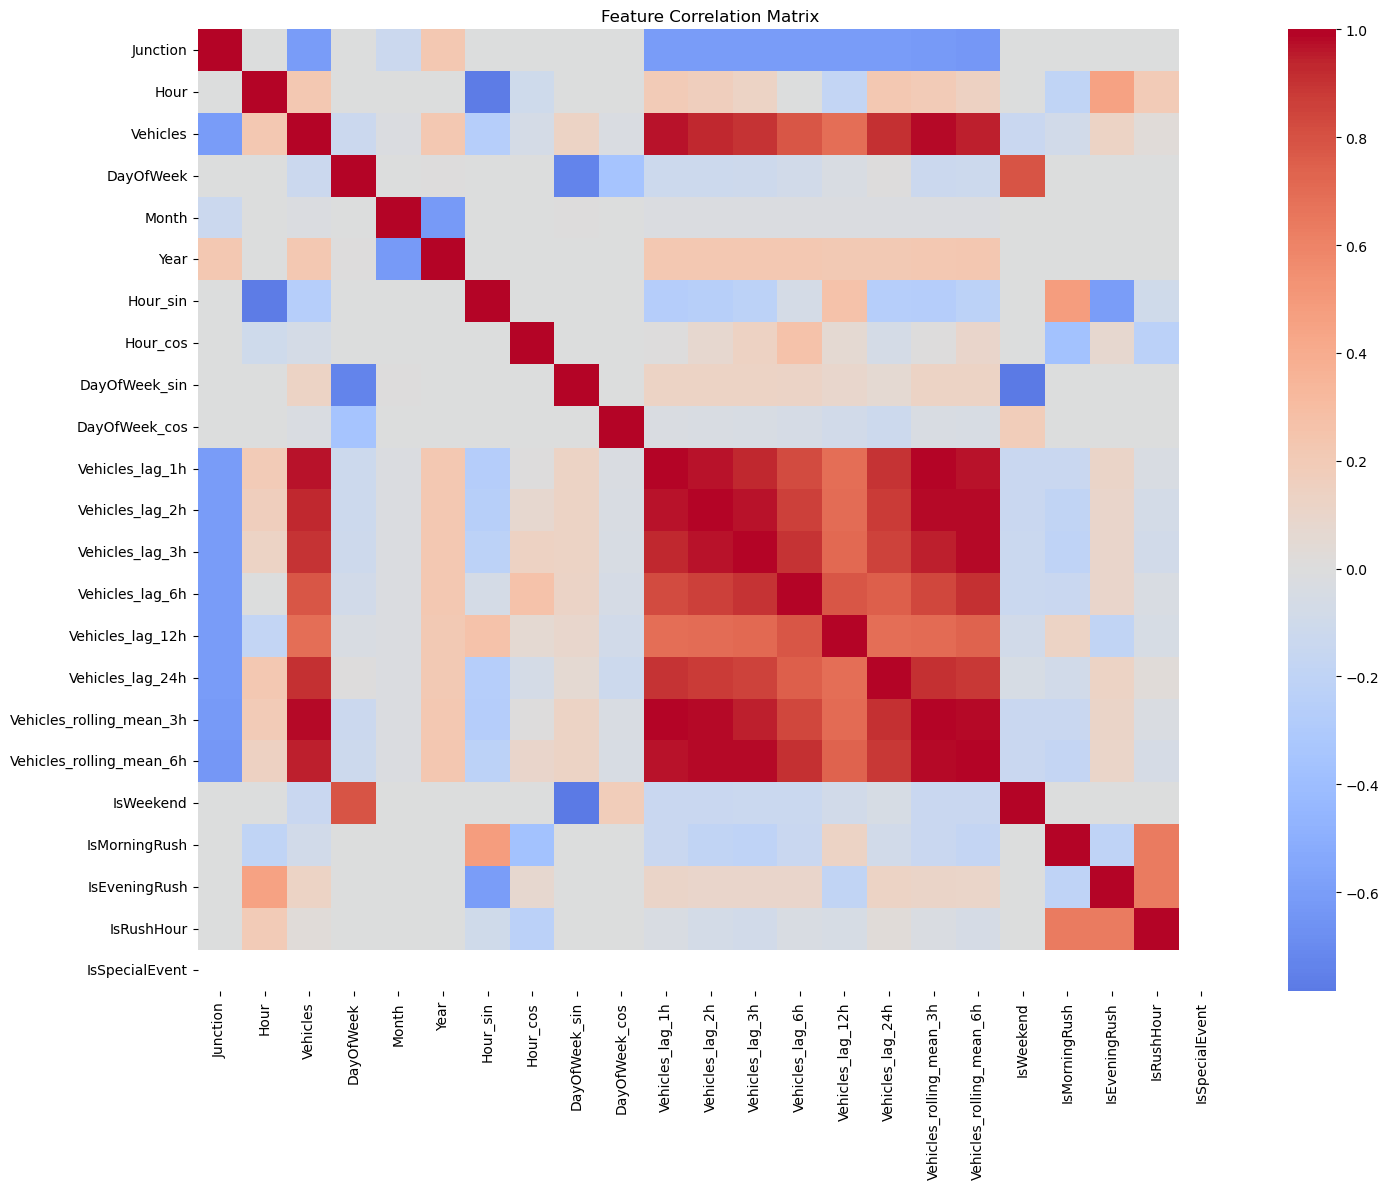

In [ ]:
# STEP 24: Visualize correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# STEP 25: Prepare features for Random Forest
feature_columns = [col for col in numeric_features
                  if col not in ['Vehicles', 'Date'] and not col.startswith('Vehicles_lag')]

lag_features = [col for col in numeric_features if col.startswith('Vehicles_lag')]
feature_columns.extend(lag_features[:3])

X = analysis_df[feature_columns].fillna(0)
y = analysis_df['Vehicles']

print(f"Features selected: {len(feature_columns)}")
feature_columns

Features selected: 19


['Junction',
 'Hour',
 'DayOfWeek',
 'Month',
 'Year',
 'Hour_sin',
 'Hour_cos',
 'DayOfWeek_sin',
 'DayOfWeek_cos',
 'Vehicles_rolling_mean_3h',
 'Vehicles_rolling_mean_6h',
 'IsWeekend',
 'IsMorningRush',
 'IsEveningRush',
 'IsRushHour',
 'IsSpecialEvent',
 'Vehicles_lag_1h',
 'Vehicles_lag_2h',
 'Vehicles_lag_3h']

In [ ]:
# STEP 26: Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X, y)

train_score = rf_model.score(X, y)
print(f"Model R² Score: {train_score:.4f}")

Model R² Score: 0.9962


In [ ]:
# STEP 27: Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance

,Feature,Importance
9,Vehicles_rolling_mean_3h,0.974428
17,Vehicles_lag_2h,0.014165
16,Vehicles_lag_1h,0.004262
1,Hour,0.002778
6,Hour_cos,0.001194
5,Hour_sin,0.001008
0,Junction,0.000550
18,Vehicles_lag_3h,0.000357
14,IsRushHour,0.000318
10,Vehicles_rolling_mean_6h,0.000313


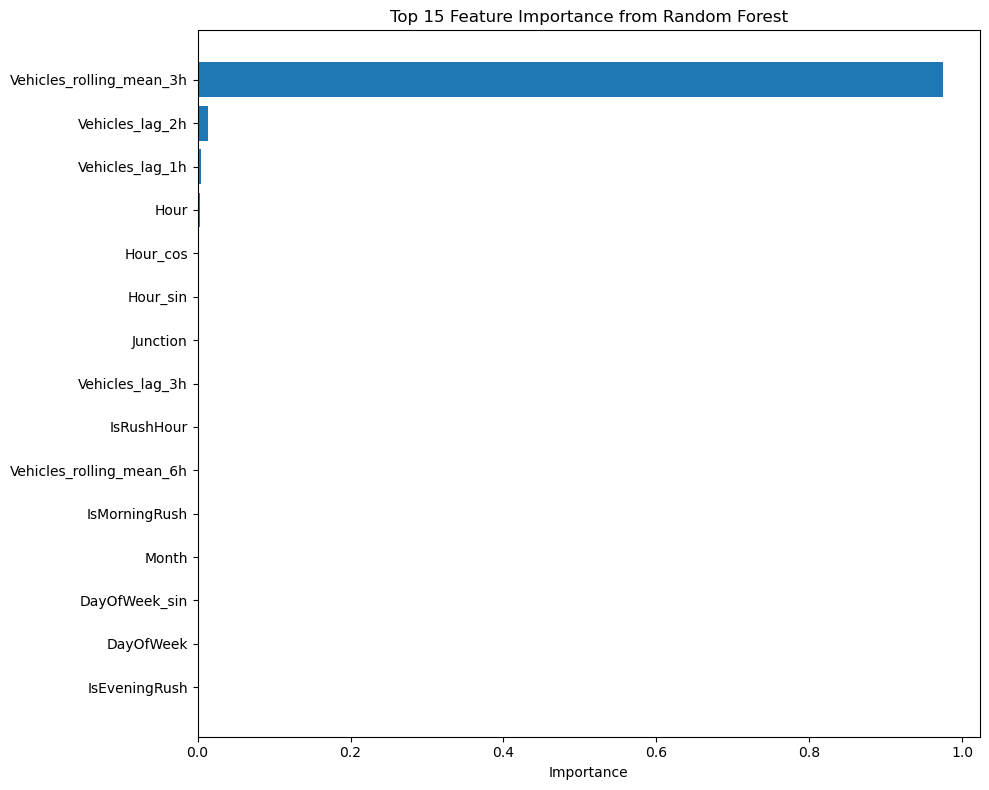

In [ ]:
# STEP 28: Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# STEP 29: Display final data info
print(f"Final dataset shape: {feature_df.shape}")
print(f"Total features created: {feature_df.shape[1]}")
feature_df.info()

Final dataset shape: (48120, 25)
Total features created: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Junction                  48120 non-null  int64  
 1   Date                      48120 non-null  object 
 2   Hour                      48120 non-null  int32  
 3   Vehicles                  48120 non-null  int64  
 4   DayOfWeek                 48120 non-null  int32  
 5   Month                     48120 non-null  int32  
 6   Year                      48120 non-null  int32  
 7   Hour_sin                  48120 non-null  float64
 8   Hour_cos                  48120 non-null  float64
 9   DayOfWeek_sin             48120 non-null  float64
 10  DayOfWeek_cos             48120 non-null  float64
 11  Vehicles_lag_1h           48116 non-null  float64
 12  Vehicles_lag_2h           48112 non-null  float64
 13  V

In [ ]:
# STEP 30: View final processed data
feature_df.head(20)

,Junction,Date,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h,IsWeekend,IsMorningRush,IsEveningRush,IsRushHour,IsSpecialEvent,TimeOfDay
0,1,2015-11-01,0,15,6,11,2015,0.000000e+00,1.000000e+00,-0.781831,0.62349,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,15.000000,1,0,0,0,0,Night
1,1,2015-11-01,1,13,6,11,2015,2.588190e-01,9.659258e-01,-0.781831,0.62349,15.0,NaN,NaN,NaN,NaN,NaN,14.000000,14.000000,1,0,0,0,0,Night
2,1,2015-11-01,2,10,6,11,2015,5.000000e-01,8.660254e-01,-0.781831,0.62349,13.0,15.0,NaN,NaN,NaN,NaN,12.666667,12.666667,1,0,0,0,0,Night
3,1,2015-11-01,3,7,6,11,2015,7.071068e-01,7.071068e-01,-0.781831,0.62349,10.0,13.0,15.0,NaN,NaN,NaN,10.000000,11.250000,1,0,0,0,0,Night
4,1,2015-11-01,4,9,6,11,2015,8.660254e-01,5.000000e-01,-0.781831,0.62349,7.0,10.0,13.0,NaN,NaN,NaN,8.666667,10.800000,1,0,0,0,0,Night
5,1,2015-11-01,5,6,6,11,2015,9.659258e-01,2.588190e-01,-0.781831,0.62349,9.0,7.0,10.0,NaN,NaN,NaN,7.333333,10.000000,1,0,0,0,0,Night
6,1,2015-11-01,6,9,6,11,2015,1.000000e+00,6.123234e-17,-0.781831,0.62349,6.0,9.0,7.0,15.0,NaN,NaN,8.000000,9.000000,1,0,0,0,0,Morning
7,1,2015-11-01,7,8,6,11,2015,9.659258e-01,-2.588190e-01,-0.781831,0.62349,9.0,6.0,9.0,13.0,NaN,NaN,7.666667,8.166667,1,1,0,1,0,Morning
8,1,2015-11-01,8,11,6,11,2015,8.660254e-01,-5.000000e-01,-0.781831,0.62349,8.0,9.0,6.0,10.0,NaN,NaN,9.333333,8.333333,1,1,0,1,0,Morning
9,1,2015-11-01,9,12,6,11,2015,7.071068e-01,-7.071068e-01,-0.781831,0.62349,11.0,8.0,9.0,7.0,NaN,NaN,10.333333,9.166667,1,1,0,1,0,Morning


In [ ]:
# STEP 31: View analysis data summary
analysis_df.describe()

,Junction,Hour,Vehicles,DayOfWeek,Month,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Vehicles_lag_1h,Vehicles_lag_2h,Vehicles_lag_3h,Vehicles_lag_6h,Vehicles_lag_12h,Vehicles_lag_24h,Vehicles_rolling_mean_3h,Vehicles_rolling_mean_6h,IsWeekend,IsMorningRush,IsEveningRush,IsRushHour,IsSpecialEvent
count,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,4.802400e+04,4.802400e+04,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.000000,48024.0
mean,2.179910,11.500000,22.822547,2.990005,5.879060,2016.271364,-1.821705e-17,-5.522449e-17,0.003512,-0.000802,22.819965,22.817425,22.814780,22.805431,22.787627,22.766867,22.819979,22.815825,0.282859,0.166667,0.166667,0.333333,0.0
std,0.966524,6.922259,20.757982,1.997495,3.566269,0.614527,7.071141e-01,7.071141e-01,0.706311,0.707907,20.756734,20.755251,20.753335,20.745438,20.731083,20.723927,20.471803,20.078670,0.450393,0.372682,0.372682,0.471409,0.0
min,1.000000,0.000000,1.000000,0.000000,1.000000,2015.000000,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.833333,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,5.750000,9.000000,1.000000,3.000000,2016.000000,-7.071068e-01,-7.071068e-01,-0.781831,-0.900969,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.166667,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,11.500000,15.000000,3.000000,5.000000,2016.000000,6.123234e-17,-6.123234e-17,0.000000,-0.222521,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.333333,15.333333,0.000000,0.000000,0.000000,0.000000,0.0
75%,3.000000,17.250000,29.000000,5.000000,9.000000,2017.000000,7.071068e-01,7.071068e-01,0.781831,0.623490,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.333333,29.500000,1.000000,0.000000,0.000000,1.000000,0.0
max,4.000000,23.000000,180.000000,6.000000,12.000000,2017.000000,1.000000e+00,1.000000e+00,0.974928,1.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,154.333333,140.500000,1.000000,1.000000,1.000000,1.000000,0.0


In [ ]:
# STEP 32: Export preprocessed data (uncomment to save)
preprocessed_data.to_csv('aggregated_preprocessed_traffic_data.csv', index=False)
feature_df.to_csv('traffic_data_with_features.csv', index=False)